In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy as scp
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import sys
import loompy
import scipy.optimize
import velocyto as vcy
import scvelo as scv
import glob
import pickle
import anndata

from collections import Counter
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Supplementary Figure 8

In [223]:
adata = scv.read("test_kallisto.loom", sparse=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Process the data

In [224]:
adata.obs["clusters"] = adata.obs["Clusters"]

In [225]:
scv.pp.filter_and_normalize(adata, min_counts=40, min_counts_u=20, n_top_genes=3000)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 21525 genes that are detected in less than 40 counts (spliced).
Filtered out 1794 genes that are detected in less than 20 counts (unspliced).
Normalized count data: X, spliced.
Logarithmized X.


In [226]:
scv.pp.moments(adata)

computing neighbors
    finished (0:00:03.71) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00.45) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


saving figure to file ./figures/velocity_pca_scvelo_pca_clusters.pdf


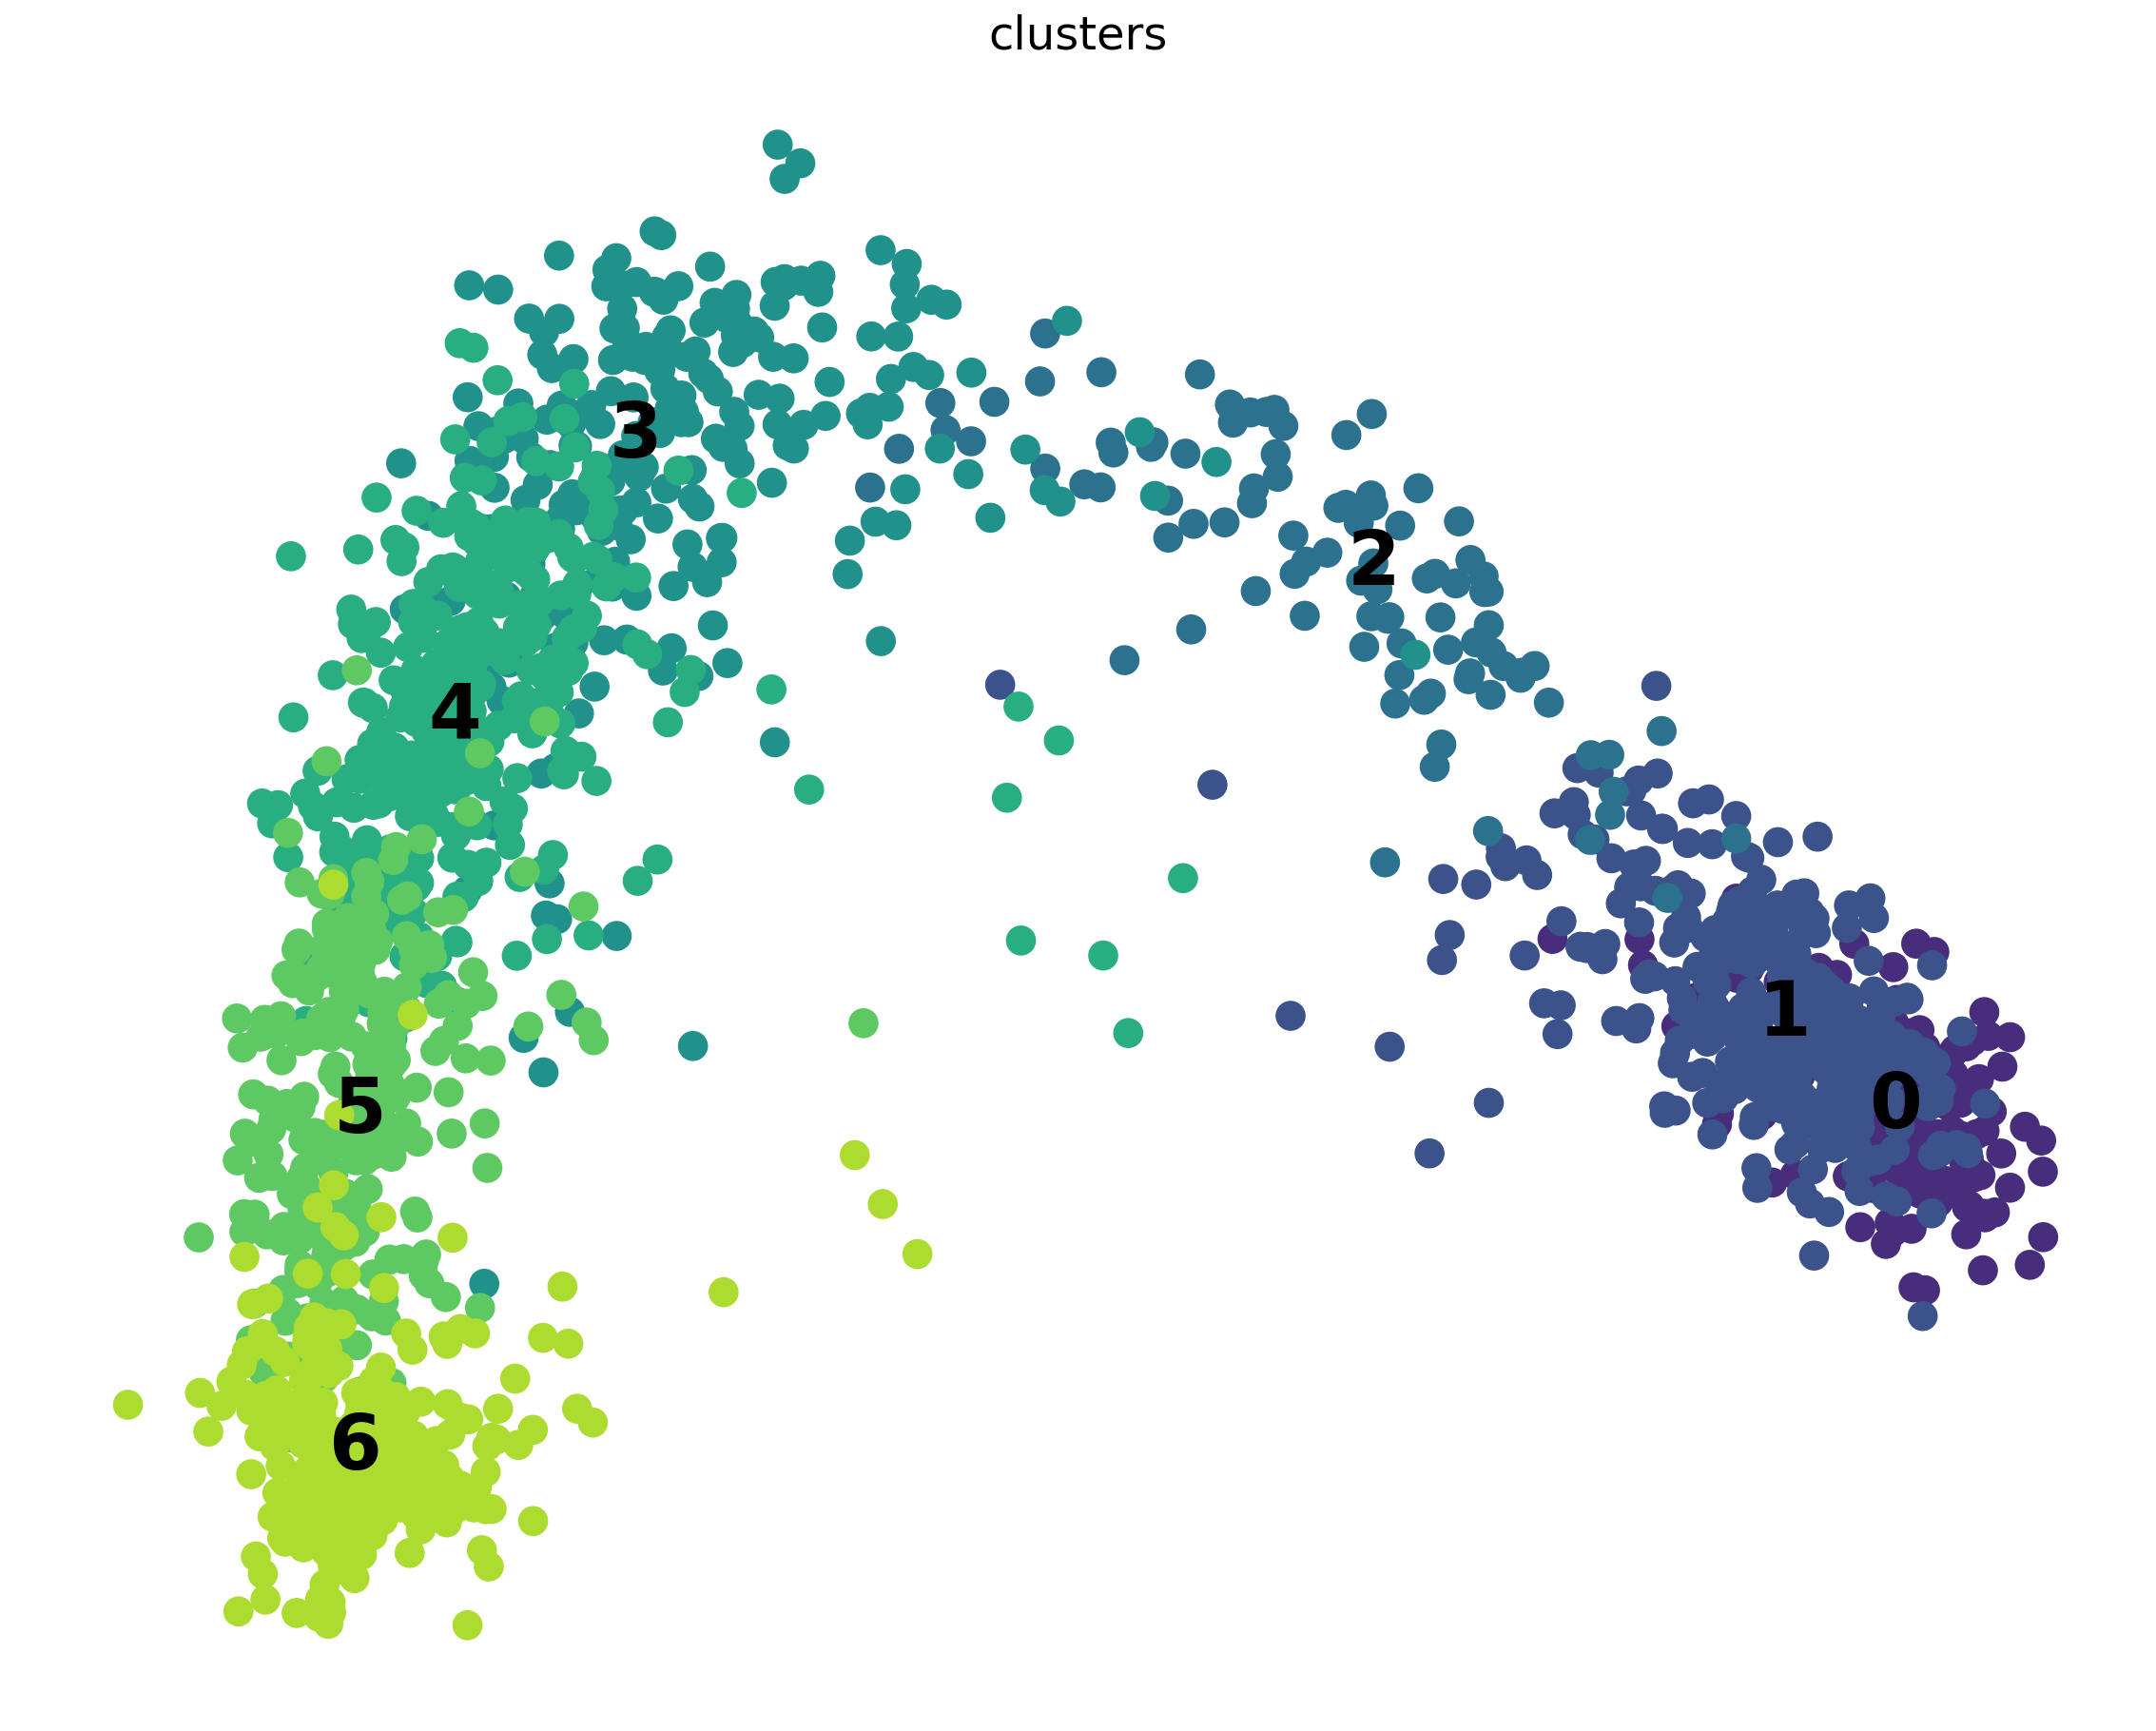

In [233]:
import numpy as np
from matplotlib import colors, cm
vals = np.array(range(adata.obs.Clusters.nunique())) + 1
vals = vals / (vals.max() + 1)
adata.uns['clusters_colors'] = [colors.to_hex(c) for c in cm.get_cmap('viridis')(vals)]

scv.pl.scatter(adata, basis='pca', color="clusters", legend_loc='on data', figsize=(20, 16), size=1000, legend_fontsize=40, save="scvelo_pca_clusters.pdf") # use colormap tab20b

### Compute velocity and velocity graph

In [228]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00.17) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [229]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:01.77) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


#### Project the cvelocity graph onto an embedding

In [230]:
scv.tl.velocity_embedding(adata, basis='pca')

computing velocity embedding
    finished (0:00:00.08) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


<Figure size 432x288 with 0 Axes>

saving figure to file ./figures/velocity_gammas.pdf


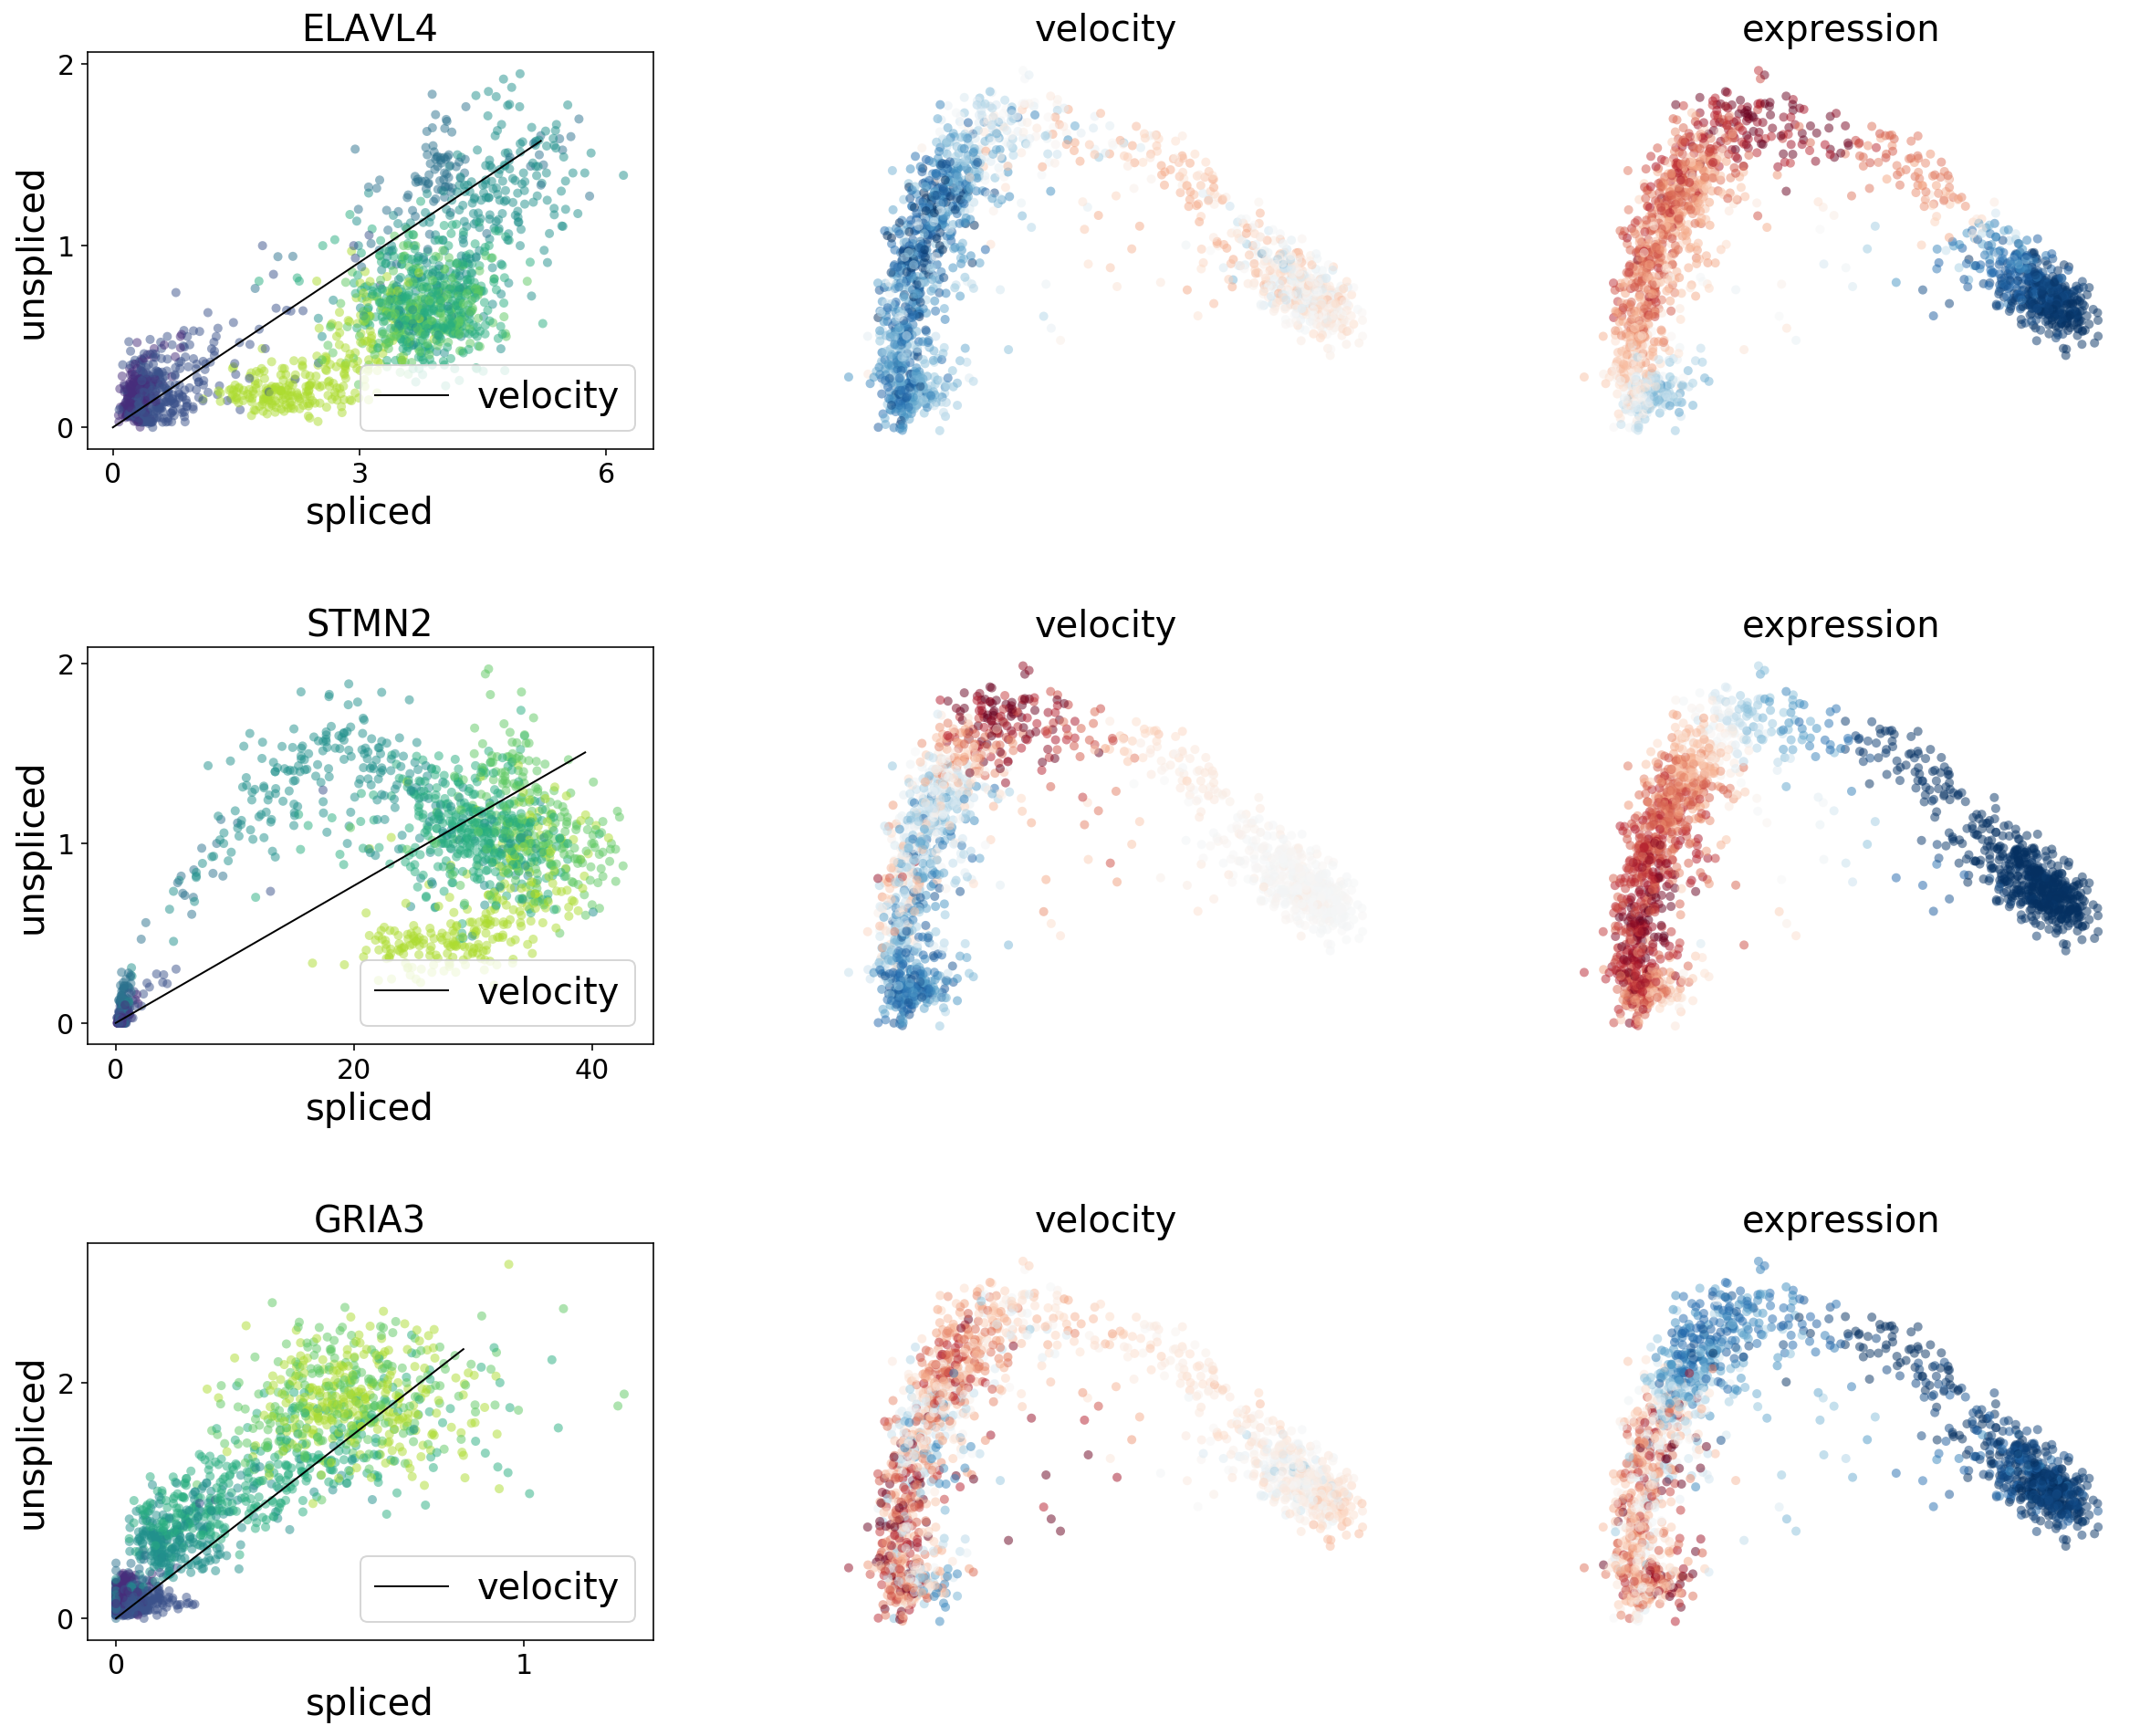

In [239]:
fig, ax = plt.subplots(figsize=(20, 16))
scv.pl.velocity(adata, basis='pca', var_names=["ELAVL4", "STMN2", "GRIA3"], size=100, ax=ax, save="gammas.pdf")
plt.show()

In [139]:
adata

AnnData object with n_obs × n_vars = 1720 × 3000 
    obs: 'Clusters', 'bcs', 'sample', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'gid', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'clusters_colors', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'velocity_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity'

## Compare to original

In [180]:
adata = scv.read("test_kallisto.loom", sparse=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [181]:
adata

AnnData object with n_obs × n_vars = 1720 × 31114 
    obs: 'Clusters', 'bcs', 'sample'
    var: 'Accession', 'gid'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [179]:
them = scv.read('data/ForebrainGlut/hgForebrainGlut.loom', cleanup=True, sparse=True, cache=True, backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
them.var_names_make_unique()
them.obs['clusters'] = them.obs['Clusters']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [182]:
them_s = np.array(them.layers["spliced"].sum(axis=1).flatten())[0]
them_u = np.array(them.layers["unspliced"].sum(axis=1).flatten())[0]

In [183]:
adata_s = np.array(adata.layers["spliced"].sum(axis=1).flatten())[0]
adata_u = np.array(adata.layers["unspliced"].sum(axis=1).flatten())[0]

In [210]:
plt.rcParams.update({'font.size': 20})

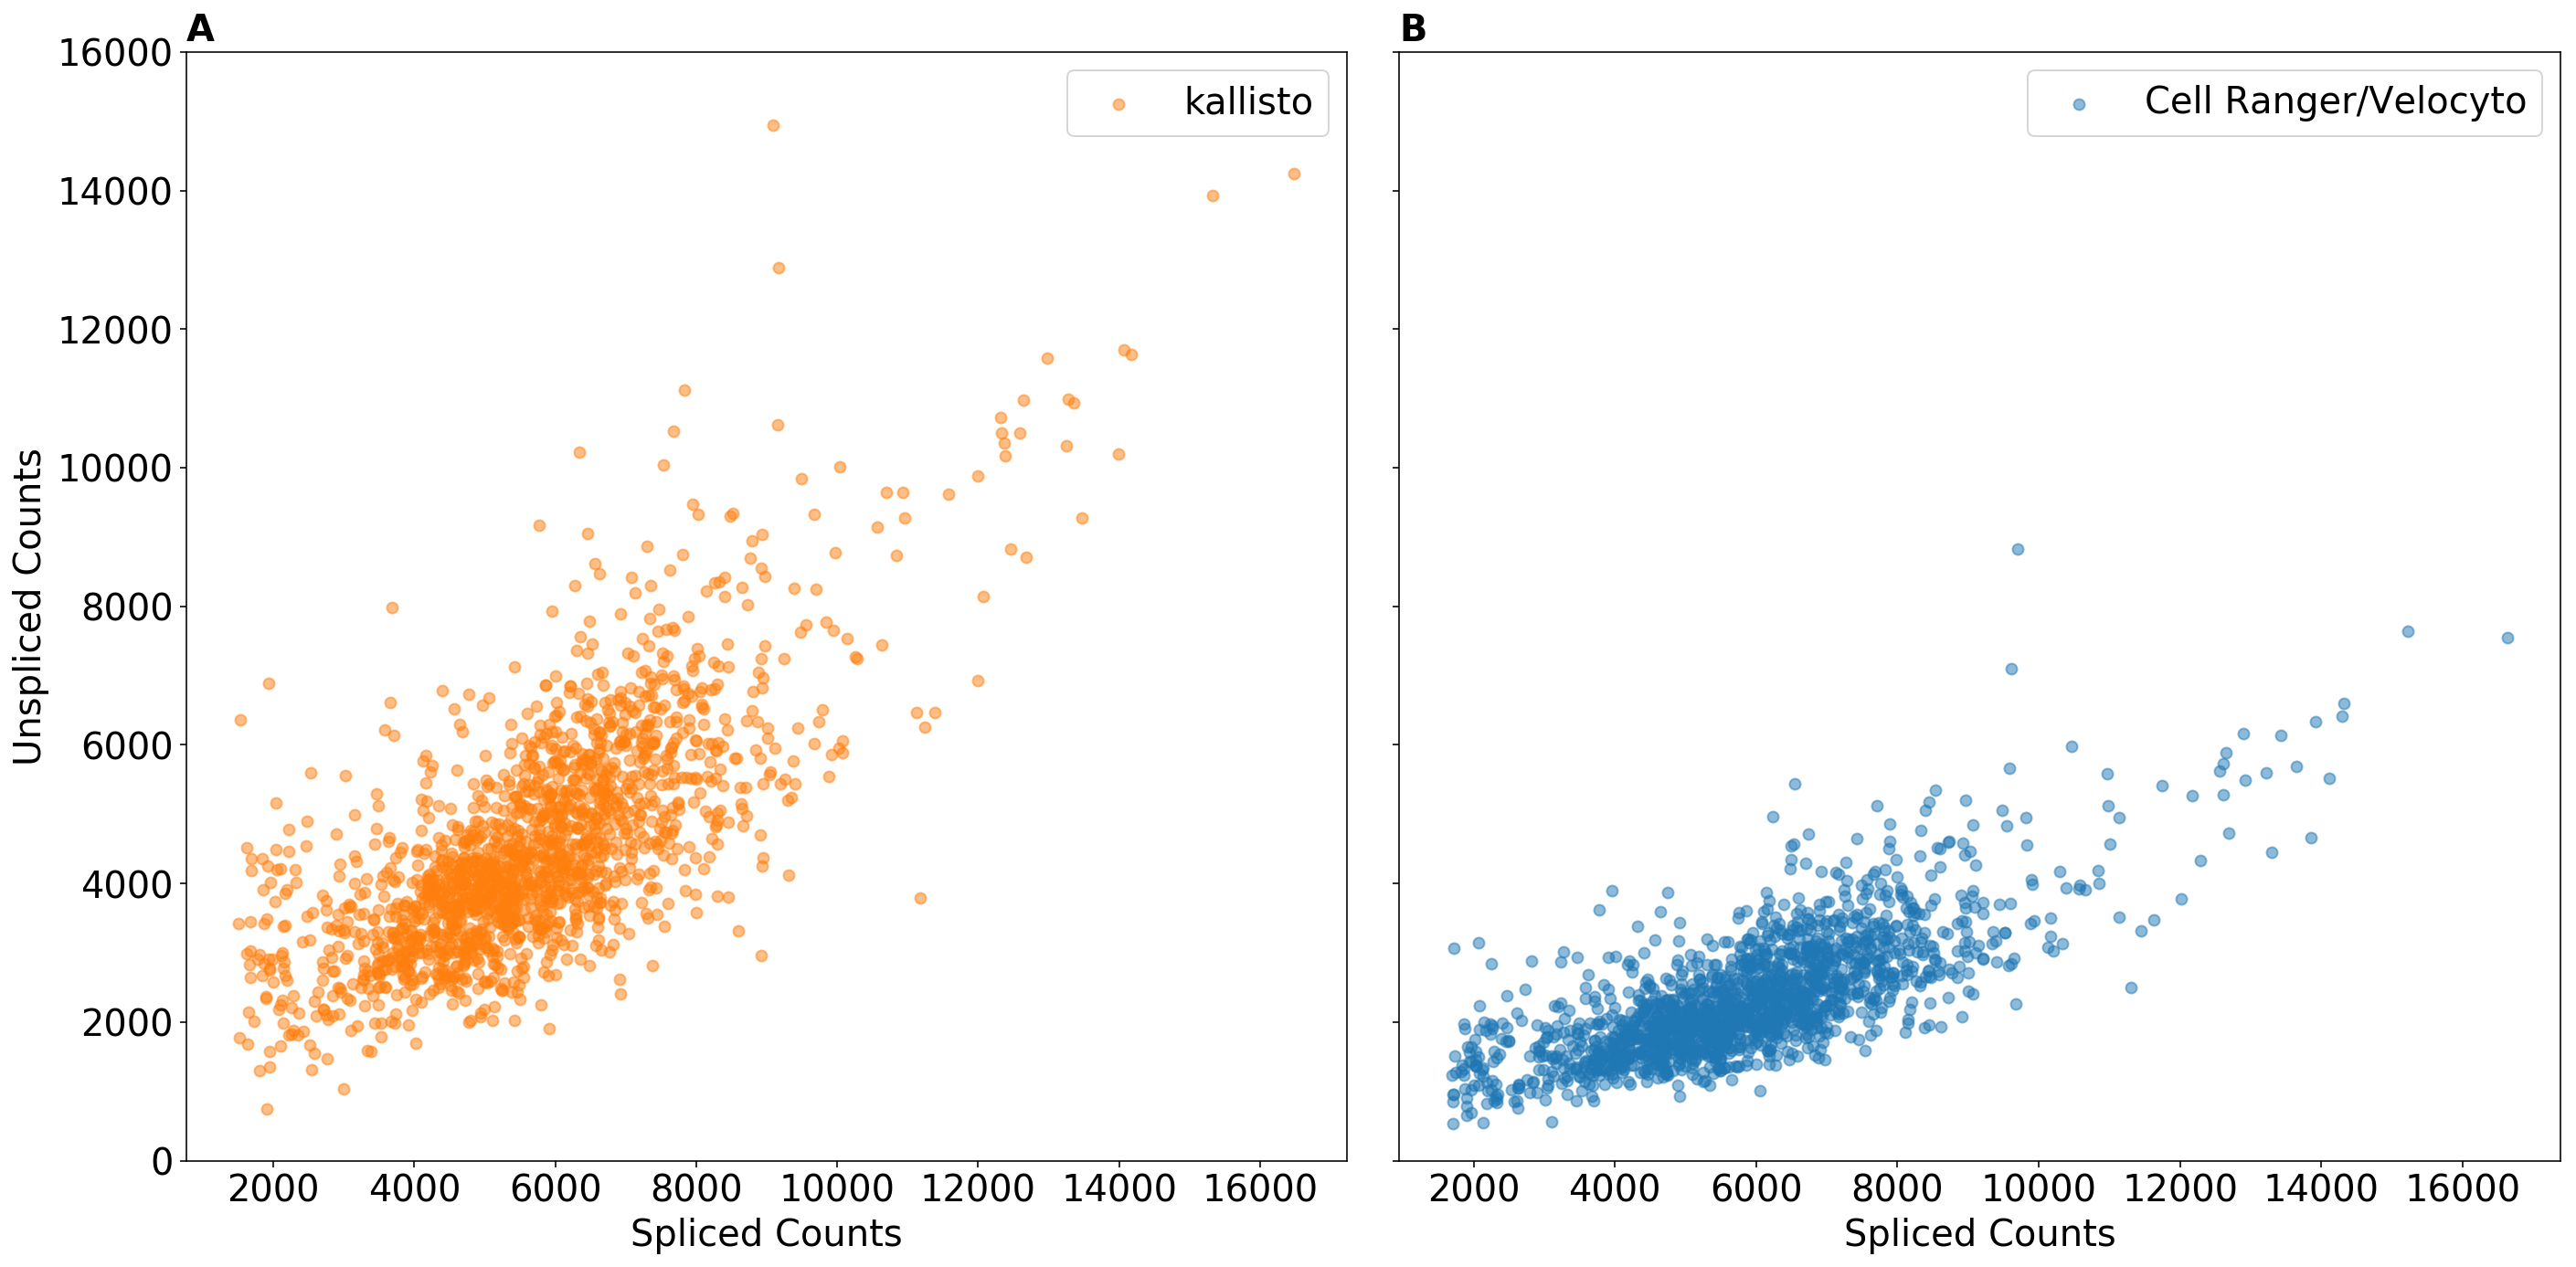

In [221]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2, sharey=True)

kallisto_color = '#FF7F0E'
tenx_color = '#1F77B4'

ax[0].scatter(adata_s, adata_u, color=kallisto_color, alpha=0.5, label="kallisto")
ax[1].scatter(them_s, them_u, color=tenx_color, alpha=0.5, label="Cell Ranger/Velocyto")

ax[0].set_xlabel("Spliced Counts")
ax[1].set_xlabel("Spliced Counts")

ax[0].set_ylim((0, 16000))
ax[1].set_ylim((0, 16000))
ax[0].set_ylabel("Unspliced Counts")
ax[0].legend()
ax[1].legend()

ax[0].set_title('',loc='center')
ax[0].set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
ax[1].set_title('',loc='center')
ax[1].set_title('B', fontweight='bold', fontsize = fsize, loc = 'left' )
plt.tight_layout()
plt.savefig("spliced_unspliced_comparison.pdf")
plt.show()